# Import CSV Data

In [34]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import json
import pprint

from datetime import datetime, timedelta
from pandas import DataFrame
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional
from keras.layers.core import Dense, Dropout
from keras.optimizers import SGD, Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

prettyprint_config = pprint.PrettyPrinter(indent=4)
prettyprint = prettyprint_config.pprint

isGdrive = True

In [35]:
if isGdrive:
    # For Google Colab
    from google.colab import drive
    from google.colab import files
    drive.mount('/content/gdrive', force_remount=True)
    df = pd.read_csv('/content/gdrive/My Drive/CS3237_Project/data.csv')
    graph_dir = '/content/gdrive/My Drive/CS3237_Project/graphs'

else:
    # For Local Runs
    df = pd.read_csv('data_combined.csv')
    # Plotting - comment out if you don't want
    cur_dir = os.getcwd()
    new_dir = cur_dir + '/graphs'
    if not os.path.exists('graphs'):
        os.makedirs('graphs')

Mounted at /content/gdrive


In [36]:
#select shots 
onlyNicholas = True
if onlyNicholas:
    df = df.drop([ i for i in range(99,249)])

In [37]:
#drop invalid shots
df = df.drop(df[(df['score'] != 1) & (df['score'] != 0)].index).reset_index(drop=True)

In [38]:
#sanity check for all invalid shots dropped
df.score.unique()


array([0, 1])

In [39]:
print(df.shape) # (totalNumberOfShots, metrics)
totalNumberOfShots = df.shape[0]
df.isnull().any()

(369, 5)


light            False
accelerometer    False
magnetometer     False
gyroscope        False
score            False
dtype: bool

In [40]:
df.head()

,light,accelerometer,magnetometer,gyroscope,score
0,"{""0"": [0.48, ""2020-10-25T09:07:15.173376""], ""1...","{""0"": [0.0, 0.0, 0.0, ""2020-10-25T09:07:15.015...","{""0"": [0.0, 0.0, 0.0, ""2020-10-25T09:07:15.021...","{""0"": [0.0, 0.0, 0.0, ""2020-10-25T09:07:15.016...",0
1,"{""0"": [775.04, ""2020-10-25T09:13:31.041089""], ...","{""0"": [0.0, 0.0, 0.0, ""2020-10-25T09:13:30.872...","{""0"": [0.0, 0.0, 0.0, ""2020-10-25T09:13:30.880...","{""0"": [0.0, 0.0, 0.0, ""2020-10-25T09:13:30.873...",1
2,"{""0"": [13.72, ""2020-10-25T09:14:19.713369""], ""...","{""0"": [0.0, 0.0, 0.0, ""2020-10-25T09:14:19.537...","{""0"": [0.0, 0.0, 0.0, ""2020-10-25T09:14:19.550...","{""0"": [0.0, 0.0, 0.0, ""2020-10-25T09:14:19.538...",1
3,"{""0"": [3.94, ""2020-10-25T09:14:32.101211""], ""1...","{""0"": [0.0, 0.0, 0.0, ""2020-10-25T09:14:31.927...","{""0"": [0.0, 0.0, 0.0, ""2020-10-25T09:14:31.933...","{""0"": [0.0, 0.0, 0.0, ""2020-10-25T09:14:31.928...",0
4,"{""0"": [4.83, ""2020-10-25T09:14:42.008443""], ""1...","{""0"": [0.0, 0.0, 0.0, ""2020-10-25T09:14:41.850...","{""0"": [0.0, 0.0, 0.0, ""2020-10-25T09:14:41.856...","{""0"": [0.0, 0.0, 0.0, ""2020-10-25T09:14:41.851...",0


In [41]:
df.tail()

,light,accelerometer,magnetometer,gyroscope,score
364,"{""0"": [0.08, ""2020-10-25T11:08:36.982468""], ""1...","{""0"": [0.111328125, 1.4345703125, 1.546875, ""2...","{""0"": [0.0, 0.0, 0.0, ""2020-10-25T11:08:36.744...","{""0"": [-10.223388671875, 41.74041748046875, 33...",0
365,"{""0"": [2.33, ""2020-10-25T11:08:45.268114""], ""1...","{""0"": [0.0, 0.0, 0.0, ""2020-10-25T11:08:44.720...","{""0"": [0.0, 0.0, 0.0, ""2020-10-25T11:08:44.726...","{""0"": [0.0, 0.0, 0.0, ""2020-10-25T11:08:44.721...",1
366,"{""0"": [5.15, ""2020-10-25T11:08:53.007532""], ""1...","{""0"": [0.0, 0.0, 0.0, ""2020-10-25T11:08:52.640...","{""0"": [0.0, 0.0, 0.0, ""2020-10-25T11:08:52.642...","{""0"": [0.0, 0.0, 0.0, ""2020-10-25T11:08:52.640...",1
367,"{""0"": [2.0100000000000002, ""2020-10-25T11:09:0...","{""0"": [0.0, 0.0, 0.0, ""2020-10-25T11:09:00.260...","{""0"": [0.0, 0.0, 0.0, ""2020-10-25T11:09:00.263...","{""0"": [0.0, 0.0, 0.0, ""2020-10-25T11:09:00.261...",0
368,"{""0"": [0.08, ""2020-10-25T11:10:44.061164""], ""1...","{""0"": [0.0, 0.0, 0.0, ""2020-10-25T11:10:43.879...","{""0"": [0.0, 0.0, 0.0, ""2020-10-25T11:10:43.883...","{""0"": [0.0, 0.0, 0.0, ""2020-10-25T11:10:43.879...",0


# Organize DataFrame into Arrays and Tuples




In [42]:
lightList = []
accelerometerList = []
gyroscopeList = []
score_master_list = [] # does not need further data organization

for shotIdx in range(totalNumberOfShots):
    lightList.append(json.loads(df.loc[shotIdx]['light']))
    accelerometerList.append(json.loads(df.loc[shotIdx]['accelerometer']))
    gyroscopeList.append(json.loads(df.loc[shotIdx]['gyroscope']))
    score_master_list.append(df.loc[shotIdx]['score'])

if (len(lightList)==len(accelerometerList)==len(gyroscopeList)==len(score_master_list)==totalNumberOfShots):
    print("Correct number of shots across all lists: %d" % totalNumberOfShots)
else:
    print("WARNING: CHECK CSV FILE!!!")

Correct number of shots across all lists: 369


In [43]:
light_master_list = []
accelerometer_master_list = []
gyroscope_master_list = []

for shotIdx in range(totalNumberOfShots):
    data_entries_list = ([(key, value) for key, value in lightList[shotIdx].items()]) # Stored as a tuple (#, [reading, timestamp])
    light_master_list.append(data_entries_list)

    data_entries_list = ([(key, value) for key, value in accelerometerList[shotIdx].items()]) # Stored as a tuple (#, [X,Y,Z, timestamp])
    accelerometer_master_list.append(data_entries_list)

    data_entries_list = ([(key, value) for key, value in gyroscopeList[shotIdx].items()]) # Stored as a tuple (#, [X,Y,Z, timestamp])
    gyroscope_master_list.append(data_entries_list)

# How to navigate the data

In [44]:
# Printing shot #0 (first shot), data point #14 that is recorded. Take note of the timestamps!
print("Light Reading: ", light_master_list[0][14])
print("Accelerometer Reading: ", accelerometer_master_list[0][14])
print("Gyroscope Reading: ", gyroscope_master_list[0][14])
print(score_master_list[0]) # does not have the extra data point parameter, because only 1 value per shot

Light Reading:  ('14', [1348.48, '2020-10-25T09:07:16.539657'])
Accelerometer Reading:  ('14', [-2.2578125, -0.00048828125, 3.3310546875, '2020-10-25T09:07:16.433804'])
Gyroscope Reading:  ('14', [61.553955078125, -110.015869140625, 54.92401123046875, '2020-10-25T09:07:16.435352'])
0


In [45]:
# To access tuple
print(light_master_list[0][14][1])

[1348.48, '2020-10-25T09:07:16.539657']


In [46]:
# To access data within tuple
print(light_master_list[0][14][1][1])

2020-10-25T09:07:16.539657


# Organize by Timestamps

In [47]:
TUPLE_DATA_POSITION = 1
LIGHT_DATA_POSITION = 0
LIGHT_TIMESTAMP_POSITION = 1
ACC_X_POSITION = 0
ACC_Y_POSITION = 1
ACC_Z_POSITION = 2
ACC_TIMESTAMP_POSITION = 3
GYRO_X_POSITION = 0
GYRO_Y_POSITION = 1
GYRO_Z_POSITION = 2
GYRO_TIMESTAMP_POSITION = 3

light_per_shot_arr = []
acc_per_shot_arr = []
gyro_per_shot_arr = []

for shotIdx in range(totalNumberOfShots):
    light_timestamp_dict = {'timestamp': [], 'reading': []}
    accelerometer_timestamp_dict = {'timestamp': [], 'X': [], 'Y': [], 'Z': []}
    gyroscope_timestamp_dict = {'timestamp': [], 'X': [], 'Y': [], 'Z': []}

    # LIGHT
    for dataPointIdx in range(len(light_master_list[shotIdx])):
        light_timestamp_dict['timestamp'].append(light_master_list[shotIdx][dataPointIdx][TUPLE_DATA_POSITION][LIGHT_TIMESTAMP_POSITION])
        light_timestamp_dict['reading'].append(light_master_list[shotIdx][dataPointIdx][TUPLE_DATA_POSITION][LIGHT_DATA_POSITION])
    light_per_shot_arr.append(light_timestamp_dict)

    # ACC
    for dataPointIdx in range(len(accelerometer_master_list[shotIdx])):
        accelerometer_timestamp_dict['timestamp'].append(accelerometer_master_list[shotIdx][dataPointIdx][TUPLE_DATA_POSITION][ACC_TIMESTAMP_POSITION])
        accelerometer_timestamp_dict['X'].append(accelerometer_master_list[shotIdx][dataPointIdx][TUPLE_DATA_POSITION][ACC_X_POSITION])
        accelerometer_timestamp_dict['Y'].append(accelerometer_master_list[shotIdx][dataPointIdx][TUPLE_DATA_POSITION][ACC_Y_POSITION])
        accelerometer_timestamp_dict['Z'].append(accelerometer_master_list[shotIdx][dataPointIdx][TUPLE_DATA_POSITION][ACC_Z_POSITION])
    acc_per_shot_arr.append(accelerometer_timestamp_dict)
    
    # GYRO
    for dataPointIdx in range(len(gyroscope_master_list[shotIdx])):
        gyroscope_timestamp_dict['timestamp'].append(gyroscope_master_list[shotIdx][dataPointIdx][TUPLE_DATA_POSITION][GYRO_TIMESTAMP_POSITION])
        gyroscope_timestamp_dict['X'].append(gyroscope_master_list[shotIdx][dataPointIdx][TUPLE_DATA_POSITION][GYRO_X_POSITION])
        gyroscope_timestamp_dict['Y'].append(gyroscope_master_list[shotIdx][dataPointIdx][TUPLE_DATA_POSITION][GYRO_Y_POSITION])
        gyroscope_timestamp_dict['Z'].append(gyroscope_master_list[shotIdx][dataPointIdx][TUPLE_DATA_POSITION][GYRO_Z_POSITION])
    gyro_per_shot_arr.append(gyroscope_timestamp_dict)

In [48]:
# Need to convert timestamp 'str' to datetime64[ns] # ACTUALLY DONT NEED ALSO CAN
#for shotIdx in range(totalNumberOfShots):
#    df_light = pd.DataFrame(light_per_shot_arr[shotIdx])
#    df_light['timestamp'] = df_light['timestamp'].astype('datetime64[ns]')
#    light_per_shot_arr[shotIdx] = df_light.to_dict()
    #print(df_light.dtypes)

In [49]:
# Example shot #0
df_light = pd.DataFrame(light_per_shot_arr[0])
df_light

,timestamp,reading
0,2020-10-25T09:07:15.173376,0.48
1,2020-10-25T09:07:15.277420,0.33
2,2020-10-25T09:07:15.331647,0.08
3,2020-10-25T09:07:15.447321,0.40
4,2020-10-25T09:07:15.553743,0.64
5,2020-10-25T09:07:15.645685,0.88
6,2020-10-25T09:07:15.764385,0.96
7,2020-10-25T09:07:15.868304,1.04
8,2020-10-25T09:07:15.962377,0.88
9,2020-10-25T09:07:16.066338,0.08


# Plot Time-Series Graphs

## LIGHT

In [ ]:
choose_shot_to_plot = 0
start_idx = 10 # Based on visual inspection
end_idx = 20 # Based on visual inspection

# Copy shot data for plot
shot = pd.DataFrame.from_dict(light_per_shot_arr[choose_shot_to_plot])
shot.set_index('timestamp', inplace=True)
shot['difference'] = shot['reading'].diff()
shot['difference'].fillna(0.0, inplace = True) # for the edge cases where the subtraction will give NA

data_temp = {'timestamp':light_per_shot_arr[choose_shot_to_plot]['timestamp'], 
             'reading':light_per_shot_arr[choose_shot_to_plot]['reading'], 
             'diff_in_reading':shot['difference'],
             'index':list(range(0,shot['reading'].size))}
graph = DataFrame(data_temp,columns=['timestamp','reading','diff_in_reading','index'])

# Marks out the point of release
start_idx = graph['index'][start_idx]
end_idx = graph['index'][end_idx] # Based on visual inspection

# Plots lines
plt.suptitle("OPT shotNumber: {}".format(choose_shot_to_plot), fontsize="x-large")
plt.subplot(211)
plt.plot(graph['index'], graph['reading'], "y")
plt.ylabel("reading")
plt.axvline(x=start_idx, linestyle='--',label='point of release',color= 'green')
plt.axvline(x=end_idx, linestyle='--',label='end of throw',color = 'green')
plt.legend()
plt.subplot(212)
plt.plot(graph['index'], graph['diff_in_reading'], "purple")
plt.ylabel("diff_in_reading")
plt.xlabel("index")
plt.legend()

# Graph saving
graph_name = "OPT_shotNumber_{}".format(choose_shot_to_plot) + '.png'
plt.savefig(f"{graph_dir}/opt/{graph_name}")

## ACCELEROMETER [X, Y, Z print separately]

In [ ]:
choose_shot_to_plot = 0
choose_metric_x = 'X'
choose_metric_y = 'Y'
choose_metric_z = 'Z'

# Copy shot data for plot
shot = pd.DataFrame.from_dict(acc_per_shot_arr[choose_shot_to_plot])
shot.set_index('timestamp', inplace=True)
shot['difference_x'] = shot[choose_metric_x].diff()
shot['difference_x'].fillna(0.0, inplace = True) # for the edge cases where the subtraction will give NA
shot['difference_y'] = shot[choose_metric_y].diff()
shot['difference_y'].fillna(0.0, inplace = True) # for the edge cases where the subtraction will give NA
shot['difference_z'] = shot[choose_metric_z].diff()
shot['difference_z'].fillna(0.0, inplace = True) # for the edge cases where the subtraction will give NA

data_temp = {'timestamp':acc_per_shot_arr[choose_shot_to_plot]['timestamp'], 
             choose_metric_x:acc_per_shot_arr[choose_shot_to_plot][choose_metric_x], 
             'diff_in_metric_x':shot['difference_x'],
             choose_metric_y:acc_per_shot_arr[choose_shot_to_plot][choose_metric_y], 
             'diff_in_metric_y':shot['difference_y'],
             choose_metric_z:acc_per_shot_arr[choose_shot_to_plot][choose_metric_z], 
             'diff_in_metric_z':shot['difference_z'],
             'index':list(range(0,shot[choose_metric_x].size))}
graph = DataFrame(data_temp,columns=['timestamp',
                                     choose_metric_x,'diff_in_metric_x',
                                     choose_metric_y,'diff_in_metric_y',
                                     choose_metric_z,'diff_in_metric_z',
                                     'index'])

# Marks out the point of release
start_idx = graph['index'][start_idx]
end_idx = graph['index'][end_idx] # Based on visual inspection

plt.figure(figsize=(20,10))

# Plot function
def plot_metric(choose_metric, diff_in_metric, pos1, pos2):
    plt.subplot(pos1)
    plt.plot(graph['index'], graph[choose_metric], "r")
    plt.ylabel(choose_metric)
    plt.axvline(x=start_idx, linestyle='--',label='point of release',color= 'green')
    plt.axvline(x=end_idx, linestyle='--',label='end of throw',color = 'green')
    plt.legend()
    plt.subplot(pos2)
    plt.plot(graph['index'], graph[diff_in_metric], "purple")
    plt.ylabel(diff_in_metric)
    plt.axvline(x=start_idx, linestyle='--',label='point of release',color= 'green')
    plt.axvline(x=end_idx, linestyle='--',label='end of throw',color = 'green')
    plt.xlabel("index")

# Plot 6 graphs
plt.suptitle("ACC shotNumber: {}".format(choose_shot_to_plot), fontsize="x-large")
plot_metric(choose_metric_x, "diff_in_metric_x", 231, 234)
plot_metric(choose_metric_y, "diff_in_metric_y", 232, 235)
plot_metric(choose_metric_z, "diff_in_metric_z", 233, 236)

# Graph saving
graph_name = "ACC_shotNumber_{}".format(choose_shot_to_plot) + '.png'
plt.savefig(f"{graph_dir}/acc/{graph_name}")

## GYROSCOPE [X, Y, Z print separately]

In [ ]:
choose_shot_to_plot = 0
choose_metric_x = 'X'
choose_metric_y = 'Y'
choose_metric_z = 'Z'

# Copy shot data for plot
shot = pd.DataFrame.from_dict(gyro_per_shot_arr[choose_shot_to_plot])
shot.set_index('timestamp', inplace=True)
shot['difference_x'] = shot[choose_metric_x].diff()
shot['difference_x'].fillna(0.0, inplace = True) # for the edge cases where the subtraction will give NA
shot['difference_y'] = shot[choose_metric_y].diff()
shot['difference_y'].fillna(0.0, inplace = True) # for the edge cases where the subtraction will give NA
shot['difference_z'] = shot[choose_metric_z].diff()
shot['difference_z'].fillna(0.0, inplace = True) # for the edge cases where the subtraction will give NA

data_temp = {'timestamp':gyro_per_shot_arr[choose_shot_to_plot]['timestamp'], 
             choose_metric_x:gyro_per_shot_arr[choose_shot_to_plot][choose_metric_x], 
             'diff_in_metric_x':shot['difference_x'],
             choose_metric_y:gyro_per_shot_arr[choose_shot_to_plot][choose_metric_y], 
             'diff_in_metric_y':shot['difference_y'],
             choose_metric_z:gyro_per_shot_arr[choose_shot_to_plot][choose_metric_z], 
             'diff_in_metric_z':shot['difference_z'],
             'index':list(range(0,shot[choose_metric_x].size))}
graph = DataFrame(data_temp,columns=['timestamp',
                                     choose_metric_x,'diff_in_metric_x',
                                     choose_metric_y,'diff_in_metric_y',
                                     choose_metric_z,'diff_in_metric_z',
                                     'index'])

# Marks out the point of release
start_idx = graph['index'][start_idx]
end_idx = graph['index'][end_idx] # Based on visual inspection

plt.figure(figsize=(20,10))

# Plot function
def plot_metric(choose_metric, diff_in_metric, pos1, pos2):
    plt.subplot(pos1)
    plt.plot(graph['index'], graph[choose_metric], "blue")
    plt.ylabel(choose_metric)
    plt.axvline(x=start_idx, linestyle='--',label='point of release',color= 'green')
    plt.axvline(x=end_idx, linestyle='--',label='end of throw',color = 'green')
    plt.legend()
    plt.subplot(pos2)
    plt.plot(graph['index'], graph[diff_in_metric], "purple")
    plt.ylabel(diff_in_metric)
    plt.axvline(x=start_idx, linestyle='--',label='point of release',color= 'green')
    plt.axvline(x=end_idx, linestyle='--',label='end of throw',color = 'green')
    plt.xlabel("index")

# Plot 6 graphs
plt.suptitle("GYR shotNumber: {}".format(choose_shot_to_plot), fontsize="x-large")
plot_metric(choose_metric_x, "diff_in_metric_x", 231, 234)
plot_metric(choose_metric_y, "diff_in_metric_y", 232, 235)
plot_metric(choose_metric_z, "diff_in_metric_z", 233, 236)

# Graph saving
graph_name = "GYR_shotNumber_{}".format(choose_shot_to_plot) + '.png'
plt.savefig(f"{graph_dir}/gyr/{graph_name}")

# ML LSTM

In [51]:
LIGHT_THRESHOLD = 400

# Calculate the index to truncate after in a timestamp sorted dataframe
def calculate_truncate_index(sorted_sample_light_df, shot_number):
  num_indexes = sorted_sample_light_df.shape[0]
  for i in range(int(num_indexes)):
    if sorted_sample_light_df.at[i, 'light'] > LIGHT_THRESHOLD:
      return i

  raise Exception(f"Light readings for shot number {shot_number} never exceeded threshold!")


def pad_data(df, list):
  padded_df = pd.DataFrame()
  #truncate data or pad data depending on the length of data
  if df.shape[0] > 10:
    truncated_df = df.iloc[df.shape[0]-10:df.shape[0]]
    return truncated_df.reset_index(drop=True)
  else:
    rows_to_add = 10 - df.shape[0]
    for rows in range(rows_to_add):
      padded_df = padded_df.append(list, ignore_index=True)
  #while padded_df.shape[0] < 15:
  #  padded_df = padded_df.append(list, ignore_index=True)
  #  padded_df.iloc[0] = list
  return padded_df.append(df, ignore_index=True)

#Merged data of shotNumber  in to 1 sample dataframe
def get_sample_df(shotNumber):
    sample_light_df = pd.DataFrame(light_per_shot_arr[shotNumber]).sort_values(["timestamp"],kind='mergesort', ignore_index=True).drop(columns=["timestamp"]).rename(columns={"reading" : "light"})
    truncate_index = calculate_truncate_index(sample_light_df, shotNumber)
    sample_light_df = sample_light_df.truncate(after=truncate_index)
    
    sample_acc_df = pd.DataFrame(acc_per_shot_arr[shotNumber]).sort_values(["timestamp"],kind='mergesort',ignore_index=True).truncate(after=truncate_index).drop(columns=["timestamp"]).rename(columns={"X": "accel_X", "Y": "accel_Y", "Z": "accel_Z"})
    sample_acc_df = pad_data(sample_acc_df,{'accel_X': 0, 'accel_Y':0, 'accel_Z': 0})

    sample_gyro_df = pd.DataFrame(gyro_per_shot_arr[shotNumber]).sort_values(["timestamp"],kind='mergesort', ignore_index=True).truncate(after=truncate_index).drop(columns=["timestamp"]).rename(columns={"X": "gyro_X", "Y": "gyro_Y", "Z": "gyro_Z"})
    sample_gyro_df = pad_data(sample_gyro_df,{'gyro_X': 0, 'gyro_Y':0, 'gyro_Z': 0})

    sample_df = pd.merge(sample_acc_df, sample_gyro_df,left_index=True, right_index=True) # Without light readings
    return sample_df, truncate_index

get_sample_df(20)


(    accel_X   accel_Y   accel_Z      gyro_X      gyro_Y      gyro_Z
 0  0.000000  0.000000  0.000000    0.000000    0.000000    0.000000
 1  0.000000  0.000000  0.000000    0.000000    0.000000    0.000000
 2 -0.404297  0.565430  1.815918  -43.045044   -1.998901   -0.381470
 3 -0.194824  0.110840  1.761230  -47.981262  -20.263672  -22.430420
 4 -0.223145 -0.013184  1.878906  -45.661926   11.367798  -16.082764
 5 -0.726074 -0.267578  2.642578  -28.930664   12.947083    4.554749
 6 -1.830078 -1.793457  7.233398   -6.332397  -25.497437  -18.745422
 7 -2.274414  0.952637  4.495117  249.992371 -247.848511  -22.666931
 8  7.351562  6.884766  4.537109 -250.000000  249.992371 -250.000000
 9 -7.890137 -0.776367  2.427246  -31.005859   42.114258 -250.000000, 8)

In [52]:
def calculate_abs_accel_at_index(sample_df, index):
  return abs(sample_df.at[index, 'accel_X']) + abs(sample_df.at[index, 'accel_Y'])+ abs(sample_df.at[index, 'accel_Z'])

#store df of each shot into dict
def truncate_data():
  truncate_index_accumulator = 0
  abs_accel_accumulator = 0
  abnormal_readings = []
  sample_df_dict = {}
  for shot_count in range(totalNumberOfShots):
      sample_df, truncate_index = get_sample_df(shot_count)
      if truncate_index > 9:
        truncate_index = 9
      truncate_index_accumulator += truncate_index
      abs_accel_at_cutoff = calculate_abs_accel_at_index(sample_df, 9)
      abs_accel_accumulator += abs_accel_at_cutoff
      # print(f"Throw Number: {shot_count+1} , Truncate Index: {truncate_index}") # For debugging...
      if  abs_accel_at_cutoff < 1:
        abnormal_readings.append({'throw_num': shot_count, 'truncate_index': truncate_index, 'abs_accel': abs_accel_at_cutoff})
      sample_df_dict[shot_count] = sample_df

  print("Average truncate index: ", truncate_index_accumulator/(totalNumberOfShots))
  print("Average accel at truncate index: ", abs_accel_accumulator/(totalNumberOfShots))
  print("Abnormal Readings: ")
  prettyprint(abnormal_readings)

  return sample_df_dict, abnormal_readings

In [53]:
#drop abnormal data
def drop_abnormal_data(sample_df_dict, abnormal_readings):
  for throw_number in abnormal_readings:
    print(throw_number['throw_num'])
    sample_df_dict.pop(throw_number['throw_num'])
    #delete from score master list as well
    del score_master_list[throw_number['throw_num']]

  return sample_df_dict

In [54]:
#combine dict_df to a single df
def collapse_dict_df(sample_df_dict):
  samples_input_df = pd.DataFrame()
  for key in sample_df_dict:
    samples_input_df = samples_input_df.append(sample_df_dict[key])
  return samples_input_df

In [55]:
#create scaler
def scale_by_minmax(df):
  scaler = MinMaxScaler(feature_range=(0,1)).fit(df)
  df = scaler.transform(df)
  return df, scaler

def scale_by_standard(df):
  scaler = StandardScaler(feature_range=(0,1)).fit(df)
  df = scaler.transform(df)

  return df, scaler

In [56]:
def preprocess_data():
    df_dict, abnormal_readings =  truncate_data()
    # print(len(df_dict))
    df_dict = drop_abnormal_data(df_dict, abnormal_readings)
    samples_input_df = collapse_dict_df(df_dict)
    normalised_samples_input_df, scaler = scale_by_minmax(samples_input_df)
    # print("type is:  " + normalised_samples_input_df.type)
    # print(normalised_samples_input_df)
    # normalised_samples_input_array = normalised_samples_input_df.to_numpy()
    normalised_samples_input_df.shape
    return normalised_samples_input_df


In [57]:
#reshape samples array
def reshape_input(input_array, samples_size, timestamp_size, features):
    X = input_array.reshape(samples_size,timestamp_size,features)
    X.shape
    print(X[0])
    y = np.array(score_master_list[:samples_size])
    y.shape
    return train_test_split(X, y, test_size=0.2)

In [58]:
# Final evaluation of the model
def evaluate_LSTM(model):
    scores = model.evaluate(X_test, y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    accuracy = scores[1]*100
    return accuracy

## Simple LSTM

In [59]:
#simple many to one LSTM
def simple_LSTM(optimizer, loss, metrics):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(timestamp_size, features)))  #using None for timestamp_size allows input with variable timestep length, but in one batchsize, length of timestep in each sample must be equal
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    history= model.fit(X_train, y_train, epochs=200, verbose=1, batch_size=16, validation_split = 0.33)

    accuracy = evaluate_LSTM(model)

    return model, history, accuracy 

## Stacked LSTM

In [60]:
def stacked_LSTM(optimizer, loss, metrics):#Stacked many to one LSTM
    model = Sequential()
    model.add(LSTM(60, activation='tanh', return_sequences=True, input_shape=(timestamp_size, features)))
    model.add(Dropout(0.2))
    model.add(LSTM(40, activation='tanh', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(30, activation='tanh', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(10, activation='tanh', return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1,activation='sigmoid'))

    model.compile(optimizer=adam, loss=loss, metrics=metrics)
    history = model.fit(X_train, y_train, epochs=200, verbose=1, batch_size=16, validation_split = 0.33)
    accuracy = evaluate_LSTM(model)
    
    return model, history, accuracy


## Bidirectional LSTM

In [61]:
def bidi_LSTM(optimizer, loss, metrics):

    model = Sequential()
    model.add(Bidirectional(LSTM(300, activation='tanh'), input_shape=(timestamp_size, features)))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    history = model.fit(X_train, y_train, epochs=200, verbose=1, batch_size=16, validation_split = 0.33)

    accuracy = evaluate_LSTM(model)

    return model, history, accuracy

## Stacked Bidirectional LSTM

In [62]:
#Stacked Bi-Di LSTM
def stacked_bidi_LSTM(optimizer, loss, metrics):

  model = Sequential()
  model.add(Bidirectional(LSTM(300, activation='tanh', return_sequences=True, input_shape=(timestamp_size, features))))
  model.add(Dropout(0.2))
  model.add(Bidirectional(LSTM(100, activation='tanh', return_sequences=True)))
  model.add(Dropout(0.2))
  model.add(Bidirectional(LSTM(50, activation='tanh', return_sequences=False)))
  model.add(Dropout(0.2))
  model.add(Dense(20, activation='tanh'))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation = 'relu'))

  model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
  history = model.fit(X_train, y_train, epochs=200, verbose=1, batch_size=16, validation_split=0.2)
  accuracy = evaluate_LSTM(model)

  return model, history, accuracy

In [63]:
samples_input_df = pd.DataFrame()
samples_input_df = preprocess_data()
samples_size = len(score_master_list)  #number of shots
timestamp_size = 10   #based on truncate value 
features = 6         #6 features(accelXYZ, gyroXYZ)
X_train, X_test, y_train, y_test = reshape_input(samples_input_df, samples_size, timestamp_size, features)

Average truncate index:  6.788617886178862
Average accel at truncate index:  10.63816837631267
Abnormal Readings: 
[   {'abs_accel': 0.0, 'throw_num': 1, 'truncate_index': 0},
    {'abs_accel': 0.0, 'throw_num': 332, 'truncate_index': 0}]
1
332
[[0.50562295 0.63367666 0.58439002 0.30391394 0.54334325 0.4586862 ]
 [0.51343557 0.61979095 0.58121614 0.20660716 0.58074311 0.46034943]
 [0.50370031 0.57694362 0.61149004 0.20294499 0.54424353 0.45842679]
 [0.48184939 0.528542   0.6543679  0.32207218 0.56183719 0.45789273]
 [0.47550164 0.5148394  0.64759289 0.41333639 0.50189975 0.48149844]
 [0.47089342 0.49777981 0.68824292 0.48508431 0.47124437 0.44538033]
 [0.23590448 0.17535668 1.         0.36740673 0.60436408 0.50116732]
 [0.49802396 0.37634852 0.14605936 1.         0.         0.33528649]
 [0.21014725 0.37897307 0.48010986 0.26108186 1.         0.21660182]
 [0.28937209 0.4137026  0.58738079 0.28606088 0.44841688 0.04246586]]


In [64]:
#sanity check
print(len(score_master_list))
print(samples_input_df)
samples_input_df.shape

367
[[0.50562295 0.63367666 0.58439002 0.30391394 0.54334325 0.4586862 ]
 [0.51343557 0.61979095 0.58121614 0.20660716 0.58074311 0.46034943]
 [0.50370031 0.57694362 0.61149004 0.20294499 0.54424353 0.45842679]
 ...
 [0.49884794 0.61268025 0.62159152 0.20840772 0.5054551  0.55895323]
 [0.48340581 0.53418784 0.66544594 0.28319219 0.51827268 0.45120928]
 [0.39771115 0.45249104 0.83646906 0.40914015 0.52315557 0.38500038]]


(3670, 6)

In [65]:
sgd_optimizer = SGD(learning_rate=0.01, momentum=0.1, nesterov=True, name="SGD")
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
loss = 'binary_crossentropy'
metrics = 'accuracy'

In [72]:
model_simple, history_simple, simple_lstm_model_accuracy = simple_LSTM(adam, loss, metrics)

Epoch 1/200
13/13 [==============================] - 0s 35ms/step - loss: 4.8793 - accuracy: 0.6837 - val_loss: 4.7706 - val_accuracy: 0.6907
Epoch 2/200
13/13 [==============================] - 0s 21ms/step - loss: 4.8793 - accuracy: 0.6837 - val_loss: 4.7706 - val_accuracy: 0.6907
Epoch 3/200
13/13 [==============================] - 0s 20ms/step - loss: 4.8793 - accuracy: 0.6837 - val_loss: 4.7706 - val_accuracy: 0.6907
Epoch 4/200
13/13 [==============================] - 0s 18ms/step - loss: 4.8793 - accuracy: 0.6837 - val_loss: 4.7706 - val_accuracy: 0.6907
Epoch 5/200
13/13 [==============================] - 0s 19ms/step - loss: 4.8793 - accuracy: 0.6837 - val_loss: 4.7706 - val_accuracy: 0.6907
Epoch 6/200
13/13 [==============================] - 0s 19ms/step - loss: 4.8793 - accuracy: 0.6837 - val_loss: 4.7706 - val_accuracy: 0.6907
Epoch 7/200
13/13 [==============================] - 0s 20ms/step - loss: 4.8793 - accuracy: 0.6837 - val_loss: 4.7706 - val_accuracy: 0.6907
Epoch 

In [73]:
model_stacked, history_stacked, stacked_lstm_model_accuracy = stacked_LSTM(adam, loss, metrics)

Epoch 1/200
13/13 [==============================] - 1s 98ms/step - loss: 0.6757 - accuracy: 0.6378 - val_loss: 0.6240 - val_accuracy: 0.6907
Epoch 2/200
13/13 [==============================] - 0s 11ms/step - loss: 0.6423 - accuracy: 0.6837 - val_loss: 0.6196 - val_accuracy: 0.6907
Epoch 3/200
13/13 [==============================] - 0s 11ms/step - loss: 0.6392 - accuracy: 0.6837 - val_loss: 0.6189 - val_accuracy: 0.6907
Epoch 4/200
13/13 [==============================] - 0s 12ms/step - loss: 0.6313 - accuracy: 0.6837 - val_loss: 0.6234 - val_accuracy: 0.6907
Epoch 5/200
13/13 [==============================] - 0s 12ms/step - loss: 0.6277 - accuracy: 0.6837 - val_loss: 0.6186 - val_accuracy: 0.6907
Epoch 6/200
13/13 [==============================] - 0s 11ms/step - loss: 0.6287 - accuracy: 0.6837 - val_loss: 0.6188 - val_accuracy: 0.6907
Epoch 7/200
13/13 [==============================] - 0s 11ms/step - loss: 0.6306 - accuracy: 0.6837 - val_loss: 0.6197 - val_accuracy: 0.6907
Epoch 

In [74]:
model_bidi, history_bidirectional, bidi_model_accuracy = bidi_LSTM(adam, loss, metrics)

Epoch 1/200
13/13 [==============================] - 1s 58ms/step - loss: 9.6595 - accuracy: 0.3469 - val_loss: 10.5330 - val_accuracy: 0.3093
Epoch 2/200
13/13 [==============================] - 0s 8ms/step - loss: 10.4255 - accuracy: 0.3163 - val_loss: 10.5330 - val_accuracy: 0.3093
Epoch 3/200
13/13 [==============================] - 0s 9ms/step - loss: 10.4255 - accuracy: 0.3163 - val_loss: 10.5330 - val_accuracy: 0.3093
Epoch 4/200
13/13 [==============================] - 0s 8ms/step - loss: 10.4255 - accuracy: 0.3163 - val_loss: 10.5330 - val_accuracy: 0.3093
Epoch 5/200
13/13 [==============================] - 0s 8ms/step - loss: 10.4255 - accuracy: 0.3163 - val_loss: 10.5330 - val_accuracy: 0.3093
Epoch 6/200
13/13 [==============================] - 0s 8ms/step - loss: 10.4255 - accuracy: 0.3163 - val_loss: 10.5330 - val_accuracy: 0.3093
Epoch 7/200
13/13 [==============================] - 0s 9ms/step - loss: 10.4255 - accuracy: 0.3163 - val_loss: 10.5330 - val_accuracy: 0.3093

In [75]:
model_stacked_bidi, history_stacked_bidirectional, stacked_bidi_model_accuracy = stacked_bidi_LSTM(adam, loss, metrics)

Epoch 1/200
15/15 [==============================] - 2s 131ms/step - loss: 9.7005 - accuracy: 0.3504 - val_loss: 10.5969 - val_accuracy: 0.3051
Epoch 2/200
15/15 [==============================] - 0s 16ms/step - loss: 10.4268 - accuracy: 0.3162 - val_loss: 10.5969 - val_accuracy: 0.3051
Epoch 3/200
15/15 [==============================] - 0s 16ms/step - loss: 10.4268 - accuracy: 0.3162 - val_loss: 10.5969 - val_accuracy: 0.3051
Epoch 4/200
15/15 [==============================] - 0s 15ms/step - loss: 10.4268 - accuracy: 0.3162 - val_loss: 10.5969 - val_accuracy: 0.3051
Epoch 5/200
15/15 [==============================] - 0s 15ms/step - loss: 10.4268 - accuracy: 0.3162 - val_loss: 10.5969 - val_accuracy: 0.3051
Epoch 6/200
15/15 [==============================] - 0s 15ms/step - loss: 10.4268 - accuracy: 0.3162 - val_loss: 10.5969 - val_accuracy: 0.3051
Epoch 7/200
15/15 [==============================] - 0s 16ms/step - loss: 10.4268 - accuracy: 0.3162 - val_loss: 10.5969 - val_accuracy:

In [76]:
#sanity check for it to not predict all 0 or 1
y_test.shape
np.count_nonzero(y_test)
predicted_y = []
predicted_y.append(model_stacked.predict_classes(X_test))
print(predicted_y)


[array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]], dtype=int32)]


# Summary of Performance

In [77]:
print("Simple LSTM Accuracy: %.2f%%" % simple_lstm_model_accuracy)
print("Stacked LSTM Accuracy: %.2f%%" % stacked_lstm_model_accuracy)
print("Bi-Di LSTM Accuracy: %.2f%%" % bidi_model_accuracy)
print("Stacked Bi-Di LSTM Accuracy: %.2f%%" % stacked_bidi_model_accuracy)

Simple LSTM Accuracy: 71.62%
Stacked LSTM Accuracy: 71.62%
Bi-Di LSTM Accuracy: 28.38%
Stacked Bi-Di LSTM Accuracy: 28.38%


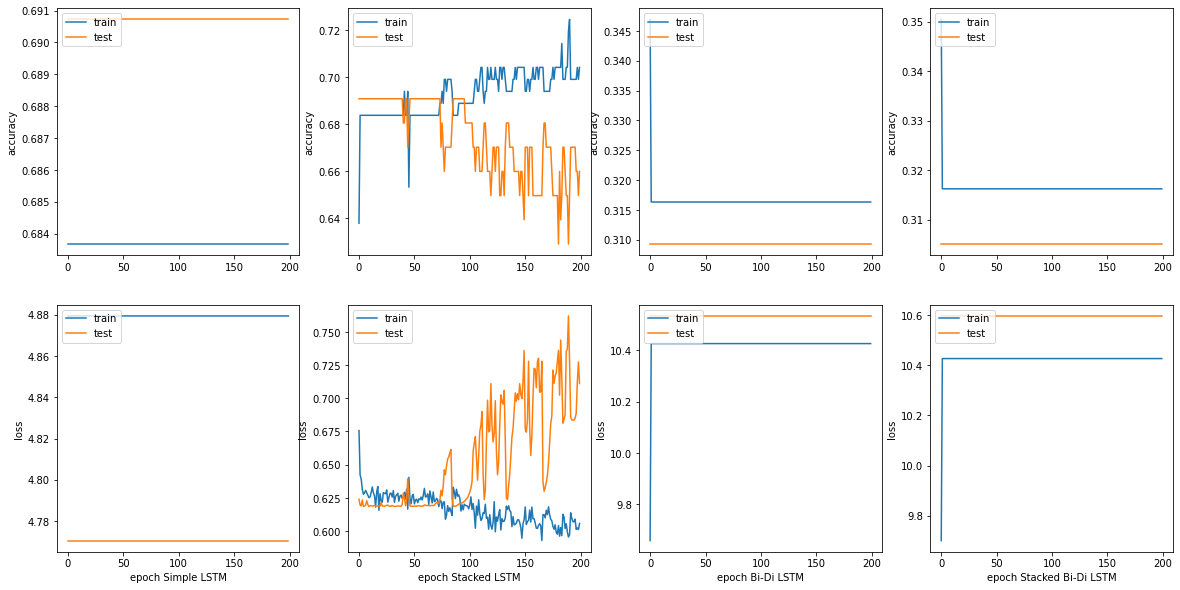

In [81]:
def plot_accuracy_and_loss(model_history, title, pos1, pos2):
    # Plot accuracy vs val_accuracy
    plt.subplot(pos1)
#    plt.suptitle(title)
    plt.plot(model_history.history['accuracy'])
    plt.plot(model_history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.legend(['train', 'test'], loc='upper left')
    # Plot loss vs val_loss
    plt.subplot(pos2)
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch ' + title)
    plt.legend(['train', 'test'], loc='upper left')

plt.figure(figsize=(20,10))

plot_accuracy_and_loss(history_simple, "Simple LSTM", 241, 245)
plot_accuracy_and_loss(history_stacked, "Stacked LSTM", 242, 246)
plot_accuracy_and_loss(history_bidirectional, "Bi-Di LSTM", 243, 247)
plot_accuracy_and_loss(history_stacked_bidirectional, "Stacked Bi-Di LSTM", 244, 248)

# Graph saving
graph_name = "Overall_Performance" + '.png'
plt.savefig(f"{graph_dir}/{graph_name}")

# Save model for prediction

In [ ]:
path = "." #path in AWS
model_stacked.save(path  + "/model_stacked:latest")

In [ ]:
#TODO SCALING AND K FOLD CROSS VAL